# Note on the Diffusion model

<a href="https://colab.research.google.com/github/ioskn/mldl_htwg/blob/master/diffusion/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explains the diffusion model and gives an example for a 1-D diffusion problem. Instead of complicated U-Nets suited for pixels, we use a simple fcNN to solve the problem. We start by explaining the details of the foreward pass and then show how to train the network. The training is done in pytorch (but it should be easy to understand it even if you are not familiar with pytorch). 

**Status:** The pytorch code still uses some fishy tricks (`unsqueeze`) to make it work.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

EXAMPLE_BIMODAL = True # True for bimodal, False for unimodal data example shown in the slides

## Forward pass simulation of the transition Kernel

To understand the transition kernel consider the transition of $x_{t-1}$ from $t-1$ to $x_t$ at time $t$. The transition is given by

$$
 q(x_t|x_{t-1})=N(\sqrt{1-\beta_t} x_{t-1},\beta_t) 
$$ 
NB: that the Normal above is parameterized by mean and **variance deviation** (as usual in math). Whereas the numpy function `np.random.normal` is parameterized by mean and **standard deviation** (as usual in code).


Given (conditioned) on $x_{t-1}$, $x_t$ is a Gaussian with mean $\sqrt{1-\beta_t} x_{t-1}$ and variance $\beta_t$. We can also write this as

$$
 x_t = x_{t-1} \cdot \sqrt{1-\beta_t} + \sqrt{\beta_t} \cdot \epsilon \quad \epsilon \sim N(0,1)
$$ 

### Simulation of the forward pass
Let's do a simulation. We start at $t=0$ from an initial distribution $x_0 \sim q(x_0)$ and simulate until $t=T$. 
Excecute one of the following cells for different initial distributions.

Text(0.5, 1.0, 'Non-Gaussian Initial Distribution t=0')

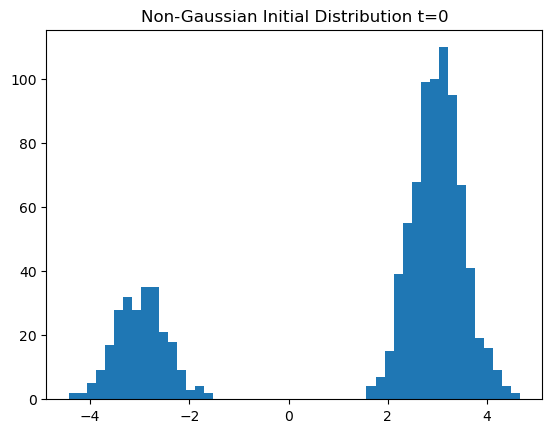

In [2]:
N = int(1e3) 
if (EXAMPLE_BIMODAL):
    xt = np.random.normal(3, 0.5, N)
    idx = np.random.choice(N, int(N/4), replace=False)
    xt[idx] = np.random.normal(-3, 0.5, len(idx))
else:
    #### Bimodal Distribution with lage offset as used in slides ####
    xt = np.random.normal(10.42, 0.5, N)
    xt[xt < 10.4] = np.random.normal(10, 0.5, len(xt[xt < 10.4]))
   
# Plotting of the initial distribution
import warnings
warnings.filterwarnings('ignore')
xt0=xt
plt.hist(xt, bins=50)
plt.title('Non-Gaussian Initial Distribution t=0')

In [3]:
####### Bimodal Distribution centered at zero (gives nice demo for the reverse path) #######



####### Uniform Distribution #######
#xt = np.random.uniform(3, 3.5, N)

#### Implementation of the forward diffusion pass

In [4]:
steps = 10 #<-- Number of time steps corresponding to T
beta = 0.4 #<-- Diffusion parameter here fixed 

t = 0
df = pd.DataFrame({
    't': [t] * N,
    'xt': xt
})

for i in range(1, steps + 1):
    t = t + 1
    xt = np.random.normal(np.sqrt(1-beta) * xt, scale=np.sqrt(beta)) #<-- Transition Kernel
    temp_df = pd.DataFrame({'t': [t] * N, 'xt': xt})
    df = pd.concat([df, temp_df])


print(df.head(3))
print(df.tail(3))

   t        xt
0  0  3.209168
1  0  1.802108
2  0 -3.210473
      t        xt
997  10 -0.231314
998  10 -0.472249
999  10 -0.229103


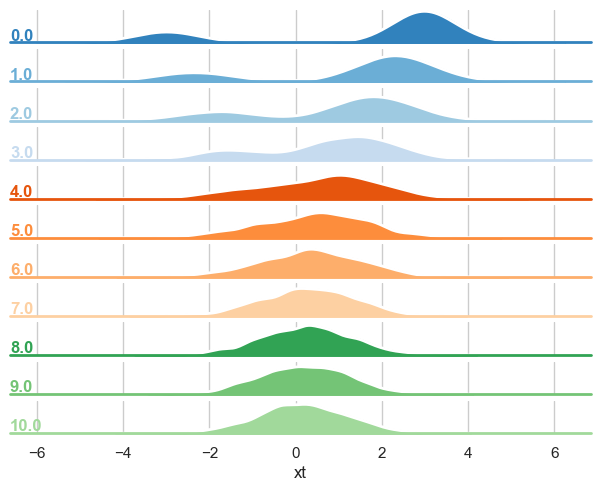

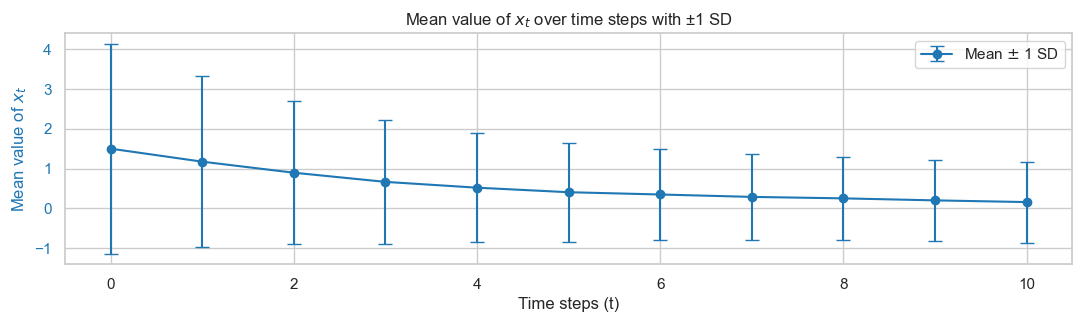

In [5]:
########## Below is plotting code only ##########
# Normalize 't' to use as y-axis value
scaler = MinMaxScaler()
df['t_org'] = df[['t']]
df['t'] = scaler.fit_transform(df[['t']])
# Round 't' to two decimal places
df['t'] = 10*df['t'].round(1)

# Plot using seaborn's kdeplot for ridge plot
sns.set(style="whitegrid")
g = sns.FacetGrid(df, row='t', hue='t', aspect=15, height=0.5, palette="tab20c")

# Draw the densities in a few steps
g.map(sns.kdeplot, 'xt', clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.2)
g.map(sns.kdeplot, 'xt', clip_on=False, color="w", lw=2, bw=0.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "xt")

# Set the subplots to overlap
#g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Show the plot
plt.show()

# Print the mean and standard deviation of the final xt
mean_xt = np.mean(xt)
sd_xt = np.std(xt)
mean_xt, sd_xt

# Creating a new DataFrame to store the mean and standard deviation at each time step
mean_sd_df = df.groupby('t').agg(
    mean_xt=('xt', 'mean'),
    sd_xt=('xt', 'std')
).reset_index()

# Creating a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(13, 3))

# Plotting the mean values of xt
ax1.errorbar(mean_sd_df['t'], mean_sd_df['mean_xt'], 
             yerr=mean_sd_df['sd_xt'], fmt='-o', capsize=5,
             label='Mean $\pm$ 1 SD', color='tab:blue')
ax1.set_xlabel('Time steps (t)')
ax1.set_ylabel('Mean value of $x_t$', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Adding a title
plt.title('Mean value of $x_t$ over time steps with ±1 SD')

# Adding a legend
ax1.legend()

plt.show()


### Direct Jump

We can directly jump to $x_t$ by sampling from $q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha_t}} x_0, (1-\bar{\alpha_t}))$ with $\bar{\alpha_t} = \sum_{i=1}^t (1 - \beta_i)$.


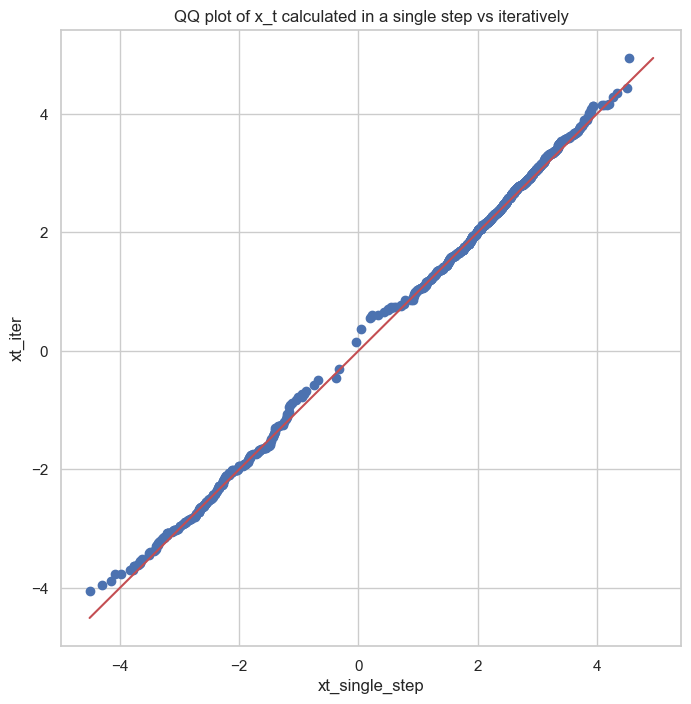

(1.1367757502518465, 2.151061530064343, 1.1744495448681087, 2.153914549482199)

In [6]:
t = 1

# Iteratively calculate the marginal distribution
xt_iter = df[df['t_org'] == t]['xt']


# Direct stops
alpha_t = (1 - beta)**t
#xt_direct = np.random.normal(xt0 * np.sqrt(alpha_t), np.sqrt(1. - alpha_t), N) 
xt_single_step = xt0 * np.sqrt(alpha_t) +  np.sqrt(1. - alpha_t) * np.random.normal(0, 1, N) 


############## Below is plotting code only ##############
# Sort the data
xt_sorted = np.sort(xt_iter)
xt_direct_sorted = np.sort(xt_single_step)

# Create the QQ plot
plt.figure(figsize=(8, 8))
plt.plot(xt_direct_sorted, xt_sorted, 'o')
plt.xlabel('xt_single_step')
plt.ylabel('xt_iter')
plt.title('QQ plot of x_t calculated in a single step vs iteratively')
plt.plot([np.min((xt_direct_sorted[0], xt_sorted[0])), np.max((xt_direct_sorted[-1], xt_sorted[-1]))], 
         [np.min((xt_direct_sorted[0], xt_sorted[0])), np.max((xt_direct_sorted[-1], xt_sorted[-1]))], 'r-')
plt.show()
np.mean(xt_single_step), np.std(xt_single_step),np.mean(xt_iter), np.std(xt_iter)

No systematic error is introduced by this direct jump. However, some observed deviations are due to the randomness of the sampling. For a more rigorous proof see the lecture slides.

# 1-Dimensional Example

Inspired by https://www.kaggle.com/code/grishasizov/simple-denoising-diffusion-model-toy-1d-example. An other good examples is  https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
n_steps = 100  # number of denoising time steps

First of all, we need to choose how the noise variance changes over time. Following the beginning of section 4 of the paper, we choose variance $1 - \alpha_t$ to change linearly from $0.001$ to $0.2$. We'll also need cumulative product $\bar\alpha_{T} = \prod\limits_{t=0}^{T} \alpha_{t}$ and its square root

In [14]:
alphas = 1. - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, axis=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - sqrt_alphas_cumprod ** 2)

The equation between eqs. (8) an (9) in the paper states that 

$$
x_t(x_0, \epsilon) = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon
$$
 
This means the quantities above detemine how much starting point $x_0$ and the noise $\epsilon$ contribute into $x_t$. Let's plot them as functions of time

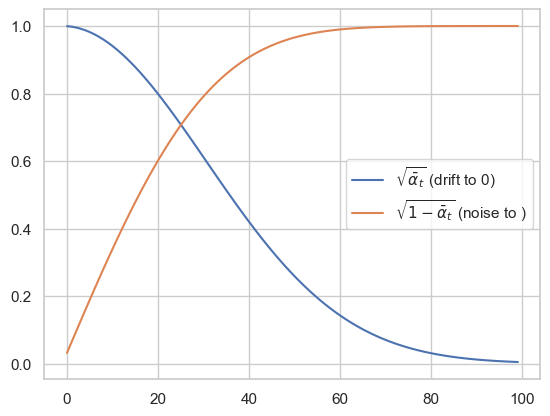

In [15]:
plt.plot(sqrt_alphas_cumprod, label=r"$\sqrt{\bar{\alpha}_t}$ (drift to 0)")
plt.plot(sqrt_one_minus_alphas_cumprod, label=r"$\sqrt{1-\bar{\alpha}_t}$ (noise to )")
plt.legend()

## Define forward diffusion step

Let's see how distribution of x evolves under the forward process - diffusion. Initially it's peaked at $x_0$, later it becames wider and centers around 0

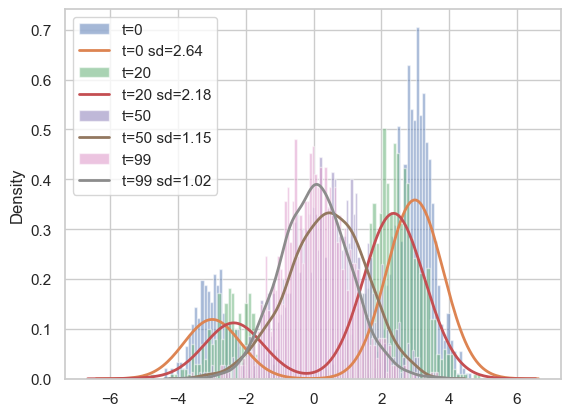

In [16]:
def q_sample(x_0, t, noise):
    """
    Sample x at time t given the value of x at t=0 and the noise
    """
    return sqrt_alphas_cumprod.gather(-1, t) * x_0 + sqrt_one_minus_alphas_cumprod.gather(-1, t) * noise

for t in [0, n_steps // 5, n_steps // 2, n_steps - 1]:
    noised_x = q_sample(xt0, torch.tensor(t), torch.randn(N))
    plt.hist(noised_x.numpy(), bins=100, alpha=0.5, label=f"t={t}", density=True);
    #Kernel Density Estimation
    sns.kdeplot(noised_x.numpy(), label=f"t={t} sd={np.std(noised_x.numpy()):.2f}", linewidth=2)
plt.legend()

## Definition and training of the model

As section 3.2 of the paper describes, we need to train a model which can predict noise $\epsilon_t$ given 
$x_t$ and $t$. The paper uses a neural net (U-Net) for this purpose. In our, much simpler case, we can use a simple fully-connected network with 2 hidden layers. The input to the network is $x_t$ and $t$ concatenated together, and the output is $\epsilon_t$. The network is trained to minimize MSE loss between the predicted $\epsilon_t$ and the true one.

In [19]:
class DenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fcnn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),  # Input layer
            torch.nn.ReLU(),  # Activation function
            torch.nn.Linear(20, 20),  # Hidden layer 1
            torch.nn.ReLU(),  # Activation function
            torch.nn.Linear(20, 1)  # Output layer
        )
        
    def forward(self, x, t):
        # Concatenate x and t along the second dimension
        input = torch.cat((x.unsqueeze(1), t.unsqueeze(1)), dim=1)
        return self.fcnn(input)

How to define a loss function? We create an instance of noise (sampled from a normal distribution) and use it to generate "noisy" $x_t$. Then we apply our model to predict the noise value based on the "noisy" $x_t$ and time $t$. The closer this predicted value is to the value of the noise we sampled initially, the better the model is:

In [20]:
def p_loss(x, t):
    # Generate a noise
    noise = torch.randn(t.shape)
    # Compute x at time t with this value of the noise - forward process
    noisy_x = q_sample(x, t, noise)
    # Use our trained model to predict the value of the noise, given x(t) and t
    noise_computed = denoise(noisy_x, t)
    # Compare predicted value of the noise with the actual value
    return F.mse_loss(noise.unsqueeze(1), noise_computed)

Below we run a simple PyTorch training loop: pick a random time step $t$, compute a loss at that time step (squared difference between actual and predicted noise), and adjust parameters $a, b, c$ based on gradients of this loss

In [22]:
denoise = DenoiseModel()
optimizer = torch.optim.Adam(denoise.parameters())

n_epochs = 5000
batch_size = N
loss_values = []
for step in range(n_epochs):
    optimizer.zero_grad()
    t = torch.randint(0, n_steps, (batch_size, ))  # Pick random time steps (different for each sample)
    loss = p_loss(xt0, t)
    loss.backward()
    if step % (n_epochs // 10) == 0:
        #print(f"loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")
        print(f"loss={loss.item():.4f}")
    loss_values.append(loss.item())
    optimizer.step()
print(f"final loss={loss.item():.4f}")

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

## Define reverse process step

Once the model is trained, we can use it to implement "backward process" (Algorith 2 from the paper). We'll go step by step from $t=99$ to $t=0$, at every step "denoising" $x_t$ to produce $x_{t-1}$. The function `p_sample` below performs one such step. Remeber  that $x_{t - 1}$ is distributed normally given $x_{t}$ - the function finds mean and variance of this distribution and then samples from it

- For posterior mean, see eq. (11) in the paper, also reused in Algorithm 2
- For posterior variance, see the beginning of section 3.2 in the paper (or eq. (7))

In [25]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1 - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
#posterior_variance = (1 - alphas) #Called first choice

def p_sample(x, t):
    """
    One step of revese process sampling - Algorithm 2 from the paper
    """
    alpha_t = alphas.gather(-1, t) # Get alphas corresponding to times t
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t)
    # Get mean x[t - 1] conditioned at x[t] - see eq. (11) in the paper
    model_mean = torch.sqrt(1.0 / alpha_t) * (x - (1 - alpha_t) * denoise(x, t).squeeze(1) / sqrt_one_minus_alphas_cumprod_t)
    # Get variance of x[t - 1]
    model_var = posterior_variance.gather(-1, t)
    # Samples for the normal distribution with given mean and variance
    return model_mean + torch.sqrt(model_var) * torch.randn(t.shape)

In [26]:
#x_gen = torch.randint(-5, 5, (1,))
#Getting a sample from normal
noise = torch.randn((4))
p_sample(noise, torch.ones_like(noise, dtype=torch.int64)*5)
denoise(noise, torch.ones_like(noise)*5), noise.shape 

(tensor([[-4.6299],
         [-5.1597],
         [-4.8309],
         [-5.0955]], grad_fn=<AddmmBackward0>),
 torch.Size([4]))

Below we apply reverse process for different random starting points $x_{100}$. You could see that all of them converge to the vicinity of true $x_0 = -5$

In [27]:

x_gens = torch.zeros((n_steps, 29999))
x_gen = torch.randn((29999))
for i in range(n_steps - 1, -1, -1): # Reverse process
    x_gen = p_sample(x_gen, torch.ones_like(x_gen, dtype=torch.int64)*i)
    x_gens[i] = x_gen
    #print(i)

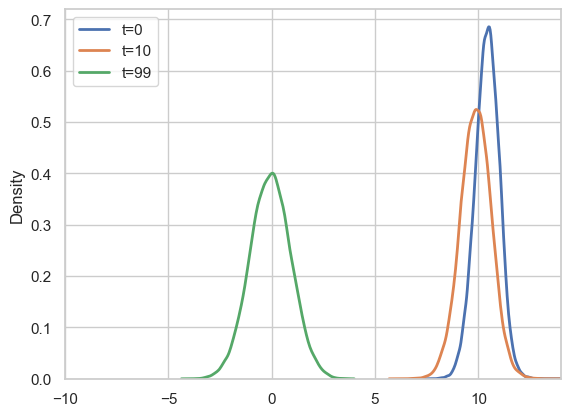

In [28]:
for t in [0, n_steps // 10, n_steps - 1]:
    x_gen = x_gens[t].detach().numpy()
    #plt.hist(x_gen, bins=10, alpha=0.5, label=f"t={t}", density=True);
    #Kernel Density Estimation
    sns.kdeplot(x_gen, label=f"t={t}", linewidth=2)
plt.xlim(-10, 14)  # Set the x-range from -10 to 10
plt.legend()


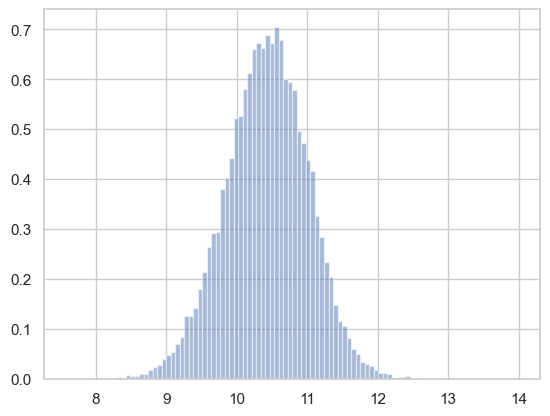

In [29]:
x_gen = x_gens[0].detach().numpy()
plt.hist(x_gen, bins=100, alpha=0.5, label=f"t={t}", density=True);

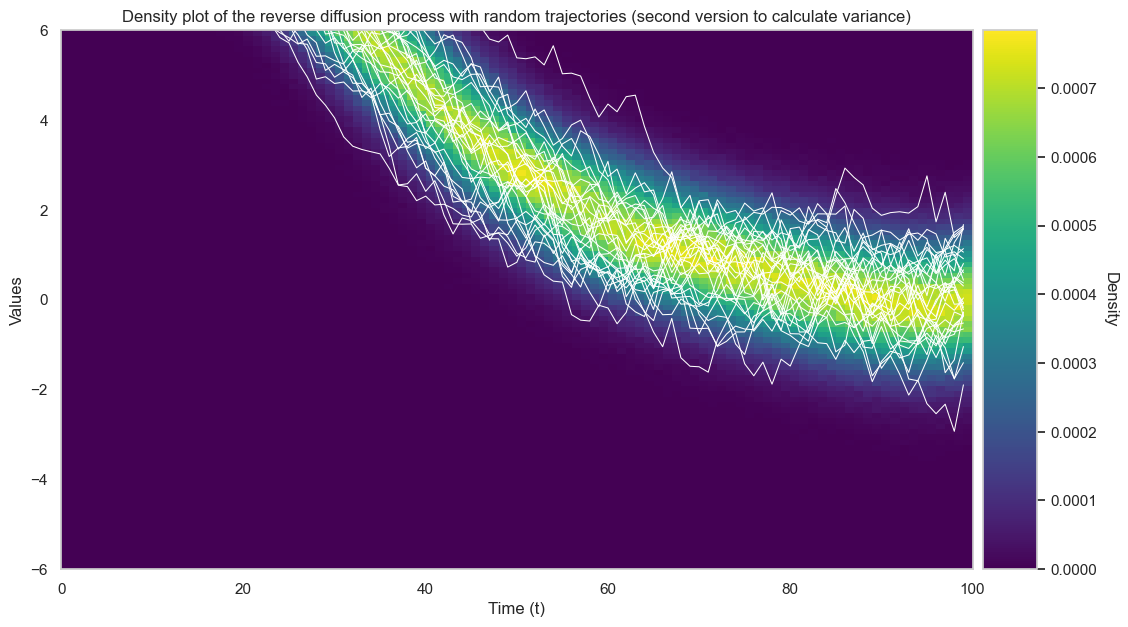

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Generating a sample (t,N) array with random data for demonstration purposes
t, N = 100, 1000  # example dimensions
data = np.random.randn(t, N)  # generating random data

# Modifying the plot_density_fast function to include random trajectories and marginal distributions
# https://chat.openai.com/c/5283123d-7975-4c5c-8336-dcc2dce8a236
def plot_density_with_trajectories_and_marginals(data, t, N):
    # Calculate the 2D histogram as before
    x_edges = np.linspace(0, t, t + 1)
    y_edges = np.linspace(-6, 6, N + 1)
    x = np.repeat(np.arange(data.shape[0]), data.shape[1])
    y = data.flatten()
    histogram, xedges, yedges = np.histogram2d(x, y, bins=(x_edges, y_edges), density=True)
    histogram /= np.sum(histogram)
    
    # Select 30 random trajectories
    trajectories = data[:, np.random.choice(data.shape[1], 30, replace=False)]
    
    # Make the plot
    fig, ax = plt.subplots(figsize=(14, 7))
    X, Y = np.meshgrid(xedges, yedges)
    pcm = ax.pcolormesh(X, Y, histogram.T, shading='auto', cmap=plt.cm.viridis)
    
    # Plot the random trajectories
    for trajectory in trajectories.T:
        ax.plot(range(t), trajectory, color='white', lw=0.75)

    # Adding colorbar
    cbar = plt.colorbar(pcm, ax=ax, pad=0.01, aspect=10)
    cbar.set_label('Density', rotation=270, labelpad=15)
    
    # Set the axis limits
    ax.set_xlim(0, t)
    ax.set_ylim(-6, 6)
    
    # Set the labels
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Values')

    plt.title('Density plot of the reverse diffusion process with random trajectories (second version to calculate variance)')
    plt.show()

# Call the function with the generated data
plot_density_with_trajectories_and_marginals(x_gens.detach().numpy(), t, 100)

